In [5]:
%pip install -qU langgraph langchain_core langchain_google_genai

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
apikey = userdata.get('GOOGLE_API_KEY')
llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp",
                                                      api_key=apikey,
                                                      temperature=0,
                                                                    )



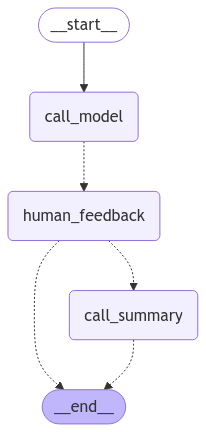

In [40]:
from langgraph.types import Command, interrupt
from langgraph.graph import START,StateGraph
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from typing import Literal, Optional
from pydantic import BaseModel
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
memory: MemorySaver = MemorySaver()
class MyAgent(BaseModel):
  summmary : Optional[str] = None
  text : Optional[str] = None
  question : str


def call_model(state) -> Command[Literal["human_feedback"]]:
  text = state.question
  text2 = llm.invoke(text).content
  return Command(update = {"text":text2},
                 goto = "human_feedback")
def human_feedback(state) -> Command[Literal["call_summary","__end__"]]:
  print("-----------interrupt human feedback node------------")
  human_feedback = interrupt({
          "question":"Is the text generated correct, should i proceed to summary?",
          "text":state.text
                             })
  if human_feedback.lower() == "yes":
    return Command(goto = "call_summary")
  else:
    print("-----not permitted to go to summary-----" )
    return (Command(goto = "__end__"))
def call_summary(state) -> Command[Literal["__end__"]]:
  text = state.text
  sys = [SystemMessage(content="write a summary of the text given below")]
  text2 = llm.invoke(sys + [text]).content
  return {"summmary":text2}

builder: StateGraph = StateGraph(MyAgent)
builder.add_node(call_model)
builder.add_node(human_feedback)
builder.add_node(call_summary)
builder.add_edge(START,"call_model")
graph : CompiledStateGraph = builder.compile(checkpointer = memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [36]:
thread = {"configurable": {"thread_id": "3"}}

# Provide initial values for 'summary' and 'text' fields
for event in graph.stream(
    {
        "question": "write a short note about crewAI",
        "summary": "",  # Initialize as an empty string or a meaningful default
        "text": "",     # Initialize as an empty string or a meaningful default
    },
    config=thread,
    stream_mode="updates"
):
    print(event)


{'call_model': {'text': "Okay, here's a short note about CrewAI:\n\n**CrewAI is a Python framework that simplifies the creation of AI agents that can collaborate to achieve complex goals. It allows you to define agents with specific roles, tools, and responsibilities, and then orchestrate their interactions to solve problems. Think of it as a way to build a team of AI specialists working together.**\n\nKey takeaways:\n\n*   **Collaboration:** Focuses on multi-agent systems.\n*   **Flexibility:** Allows for custom agent roles and tools.\n*   **Orchestration:** Provides tools to manage agent interactions.\n*   **Python-based:** Easy to integrate into existing Python workflows.\n\nIn short, CrewAI is a powerful tool for building more sophisticated and capable AI applications by leveraging the power of collaborative agents."}}
-----------interrupt human feedback node------------
{'__interrupt__': (Interrupt(value={'question': 'Is the text generated correct, should i proceed to summary?', '

In [37]:
current = graph.get_state(thread)
print(current)

StateSnapshot(values={'text': "Okay, here's a short note about CrewAI:\n\n**CrewAI is a Python framework that simplifies the creation of AI agents that can collaborate to achieve complex goals. It allows you to define agents with specific roles, tools, and responsibilities, and then orchestrate their interactions to solve problems. Think of it as a way to build a team of AI specialists working together.**\n\nKey takeaways:\n\n*   **Collaboration:** Focuses on multi-agent systems.\n*   **Flexibility:** Allows for custom agent roles and tools.\n*   **Orchestration:** Provides tools to manage agent interactions.\n*   **Python-based:** Easy to integrate into existing Python workflows.\n\nIn short, CrewAI is a powerful tool for building more sophisticated and capable AI applications by leveraging the power of collaborative agents.", 'question': 'write a short note about crewAI'}, next=('human_feedback',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'checkpoint_id': '1efd

In [38]:
current.next

('human_feedback',)

In [39]:
b = graph.invoke(Command(resume="Yes"),config=thread)
print(b)

-----------interrupt human feedback node------------
{'summmary': "Okay, here's a summary of the provided text about CrewAI:\n\n**CrewAI is a Python framework designed to facilitate the creation of collaborative AI agent systems. It enables users to define individual agents with specific roles, tools, and responsibilities, and then orchestrate their interactions to achieve complex goals. Essentially, it allows you to build a team of AI specialists working together. Key features include its focus on multi-agent collaboration, flexibility in defining agent roles and tools, tools for managing agent interactions, and its Python-based nature, making it easy to integrate into existing workflows. In essence, CrewAI empowers the development of more sophisticated AI applications through the power of collaborative agents.**", 'text': "Okay, here's a short note about CrewAI:\n\n**CrewAI is a Python framework that simplifies the creation of AI agents that can collaborate to achieve complex goals. 

In [47]:
thread = {"configurable": {"thread_id": "999"}}

# Provide initial values for 'summary' and 'text' fields
for event in graph.stream(
    {
        "question": "write a short note about crewAI",
        "summary": "",  # Initialize as an empty string or a meaningful default
        "text": "",     # Initialize as an empty string or a meaningful default
    },
    config=thread,
    stream_mode="updates"
):
    print(event)

{'call_model': {'text': "Okay, here's a short note about CrewAI:\n\n**CrewAI is a Python framework that simplifies the creation of AI agents that can collaborate to achieve complex goals. It allows you to define agents with specific roles, tools, and responsibilities, and then orchestrate their interactions to solve problems. Think of it as a way to build a team of AI specialists working together.**\n\nKey takeaways:\n\n*   **Collaboration:** Focuses on multi-agent systems.\n*   **Flexibility:** Allows for custom agent roles and tools.\n*   **Orchestration:** Provides tools to manage agent interactions.\n*   **Python-based:** Easy to integrate into existing Python workflows.\n\nIn short, CrewAI is a powerful tool for building more sophisticated and capable AI applications by leveraging the power of collaborative agents."}}
-----------interrupt human feedback node------------
{'__interrupt__': (Interrupt(value={'question': 'Is the text generated correct, should i proceed to summary?', '

In [48]:
b = graph.invoke(Command(resume="no"),config=thread)
print(b)

-----------interrupt human feedback node------------
-----not permitted to go to summary-----
{'text': "Okay, here's a short note about CrewAI:\n\n**CrewAI is a Python framework that simplifies the creation of AI agents that can collaborate to achieve complex goals. It allows you to define agents with specific roles, tools, and responsibilities, and then orchestrate their interactions to solve problems. Think of it as a way to build a team of AI specialists working together.**\n\nKey takeaways:\n\n*   **Collaboration:** Focuses on multi-agent systems.\n*   **Flexibility:** Allows for custom agent roles and tools.\n*   **Orchestration:** Provides tools to manage agent interactions.\n*   **Python-based:** Easy to integrate into existing Python workflows.\n\nIn short, CrewAI is a powerful tool for building more sophisticated and capable AI applications by leveraging the power of collaborative agents.", 'question': 'write a short note about crewAI'}
